<a href="https://colab.research.google.com/github/sean-halpin/cycle_gan_aif1_mouth_only/blob/cyclegan_from_serialized_model/cyclegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset


In [ ]:
import urllib.request
url = "https://inc.ucsd.edu/mplab/databases/GENKI-R2009a.zip"
file_name = "GENKI.zip"
urllib.request.urlretrieve(url, file_name)


import io, zipfile
archive = zipfile.ZipFile('GENKI.zip', 'r')
archive.extractall("dataset/")

import pandas as pd 
# From the file dataset/GENKI-R2009a/Subsets/GENKI-4K/README.md , we can see the meaning of the labels
# We are interested in if the person is smiling or not
data = pd.read_csv(
    "dataset/GENKI-R2009a/Subsets/GENKI-4K/GENKI-4K_Labels.txt", 
    sep=" ", 
    header=None, 
    names=["smile", "pitch","yaw","roll"],
    index_col=None
)

image_symlink_location = "dataset/GENKI-R2009a/Subsets/GENKI-4K/files/"

df1 = data
df1['index_col'] = df1.index
df1['image'] = df1.apply(lambda x: image_symlink_location + "file" + str(int(x['index_col'] + 1)).zfill(4) + ".jpg", axis=1)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [21]:
from matplotlib import pyplot as plt
import cv2

smiles = df1.loc[df1['smile'] == 1]
neutral = df1.loc[df1['smile'] == 0]

# Model Building

### Prepare Dataset for use

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 14.6MB/s 


In [2]:
# Imports
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
print(tf.__version__)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True

session = InteractiveSession(config=config)

2.4.1


In [3]:
from os import listdir
from os.path import isfile, join
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
strategy = tf.distribute.get_strategy()

In [5]:
image_x = 128
image_y = 64

IMAGE_SIZE = [image_y, image_x]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
SMILE_FILENAMES = tf.io.gfile.glob(str('/content/drive/MyDrive/smiles_tfrec/smiles*.tfrec'))
print('Smile TFRecord Files:', len(SMILE_FILENAMES))

NEUTRAL_FILENAMES = tf.io.gfile.glob(str('/content/drive/MyDrive/neutral_tfrec/neutral*.tfrec'))
print('neutral TFRecord Files:', len(NEUTRAL_FILENAMES))

Smile TFRecord Files: 1
neutral TFRecord Files: 1


In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [9]:
smile_ds = load_dataset(SMILE_FILENAMES, labeled=True).batch(1)
neutral_ds = load_dataset(NEUTRAL_FILENAMES, labeled=True).batch(1)

In [10]:
example_smile = next(iter(smile_ds))
example_neutral = next(iter(neutral_ds))

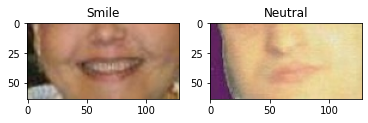

In [11]:
plt.subplot(121)
plt.title('Smile')
plt.imshow(example_smile[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Neutral')
plt.imshow(example_neutral[0] * 0.5 + 0.5)

# Helper Functions

In [13]:
!mkdir -p models

In [23]:
def printSmileFaces(epoch=0,num=5):
  _, ax = plt.subplots(num, 2, figsize=(12, 16))
  for i, img in enumerate(neutral_ds.take(num)):
      prediction = smile_generator(img, training=False)[0].numpy()
      prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
      img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

      ax[i, 0].imshow(img)
      ax[i, 1].imshow(prediction)
      ax[i, 0].set_title("Input Photo")
      ax[i, 1].set_title("Generated Smile Photo")
      ax[i, 0].axis("off")
      ax[i, 1].axis("off")
  plt.show()
  

In [24]:
def printNeutralFaces(epoch=0, num=5):
  _, ax = plt.subplots(num, 2, figsize=(12, 16))
  for i, img in enumerate(smile_ds.take(num)):
      prediction = neutral_generator(img, training=False)[0].numpy()
      prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
      img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

      ax[i, 0].imshow(img)
      ax[i, 1].imshow(prediction)
      ax[i, 0].set_title("Input Photo")
      ax[i, 1].set_title("Generated Nuetral Photo")
      ax[i, 0].axis("off")
      ax[i, 1].axis("off")
  plt.show()
  

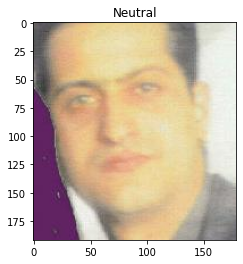

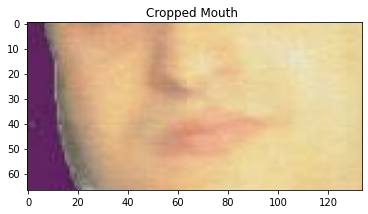

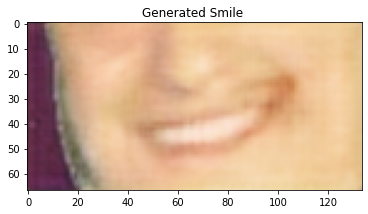

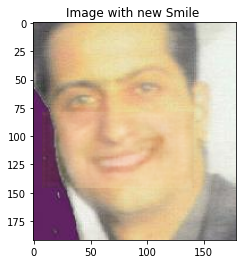

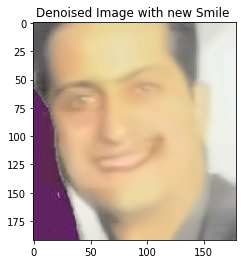

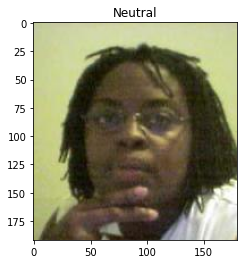

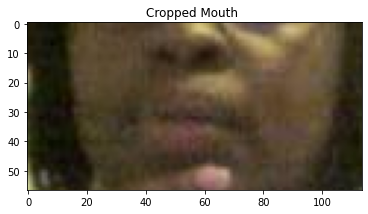

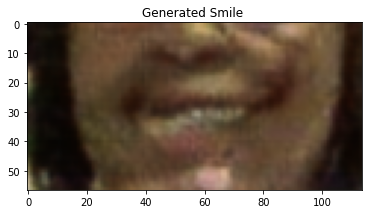

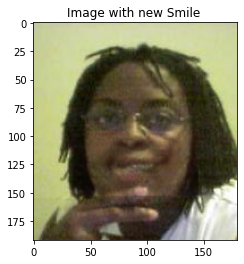

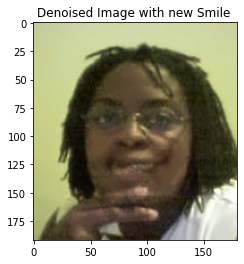

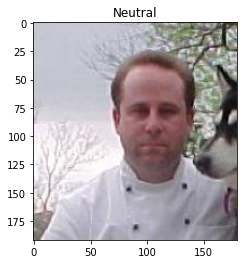

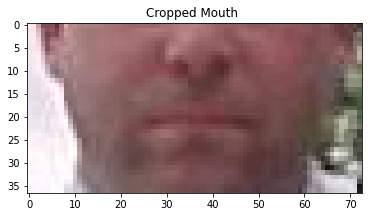

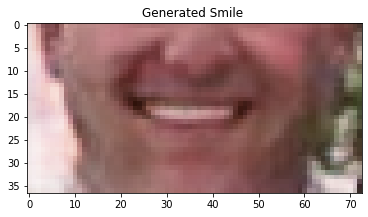

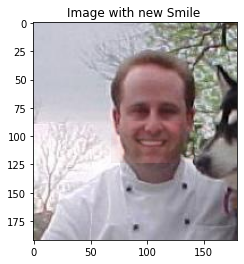

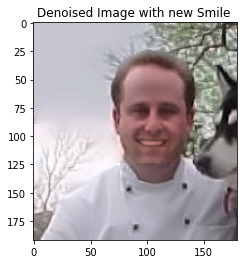

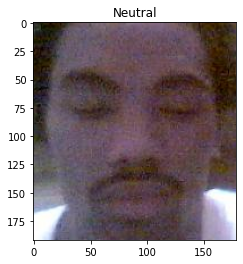

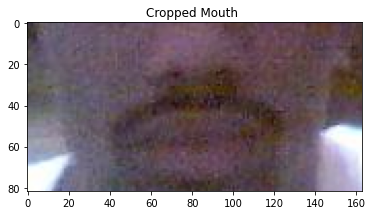

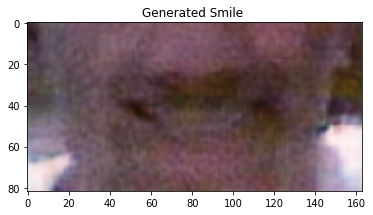

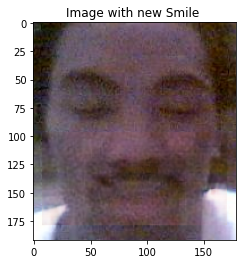

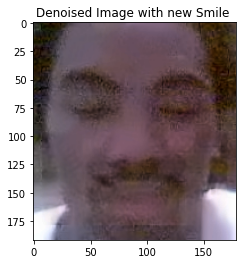

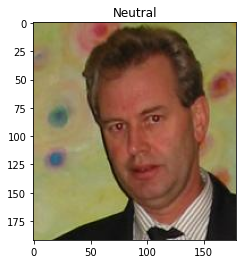

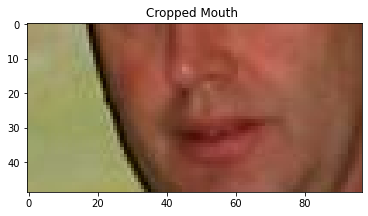

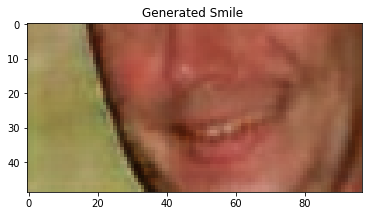

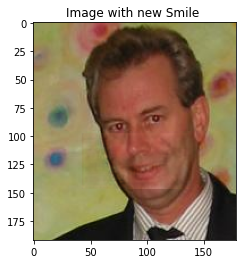

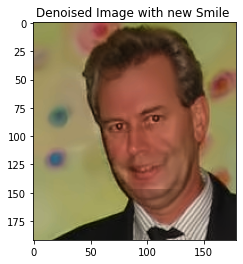

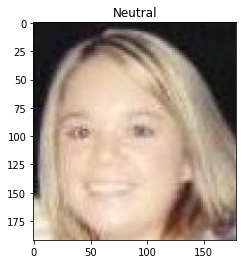

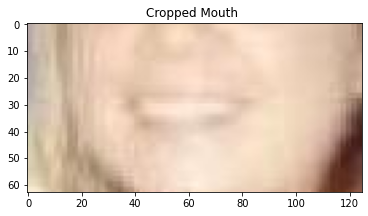

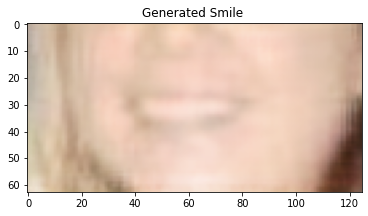

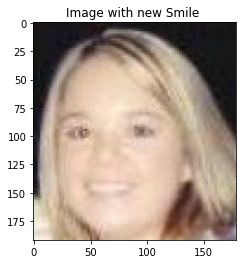

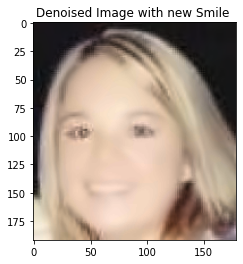

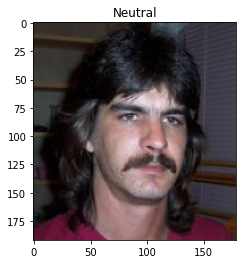

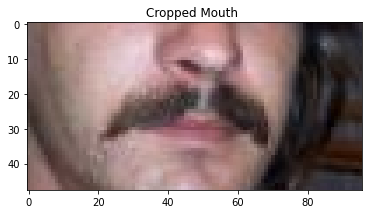

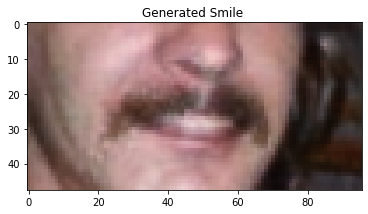

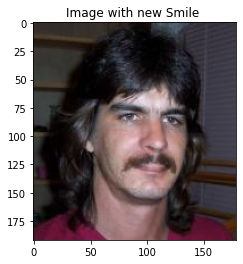

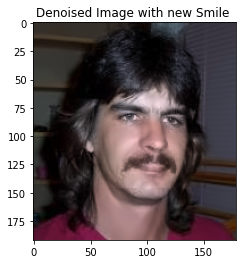

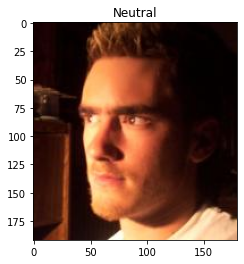

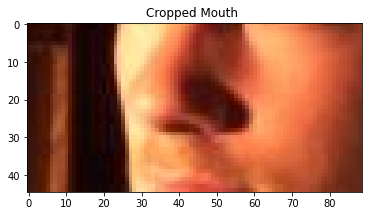

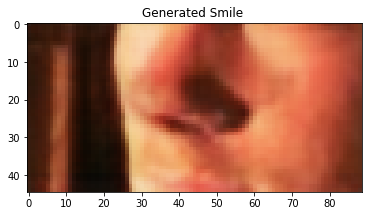

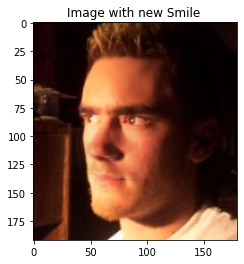

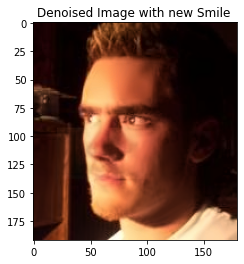

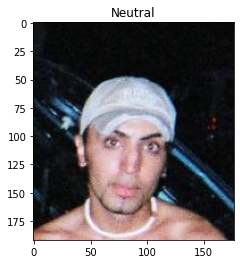

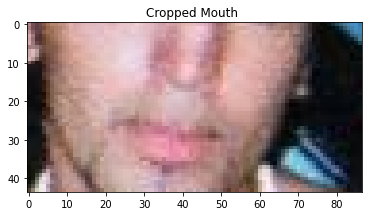

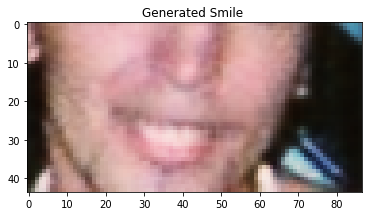

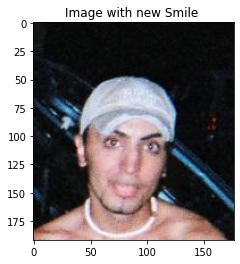

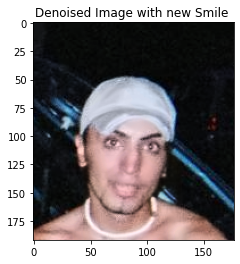

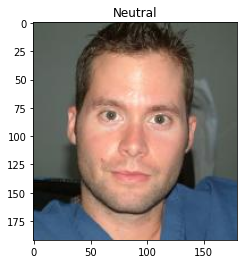

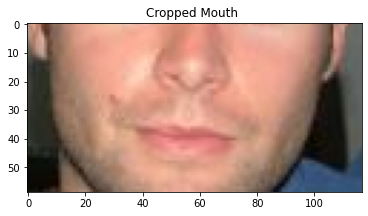

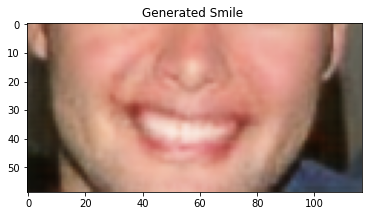

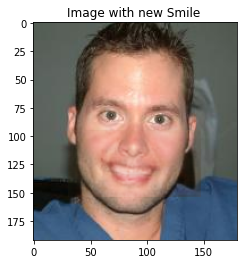

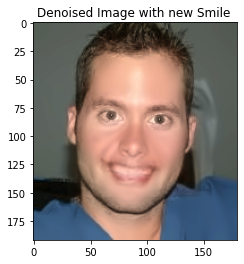

In [25]:
from PIL import Image
def predict(input):
    input = tf.reshape(tf.keras.preprocessing.image.img_to_array(input), [*IMAGE_SIZE, 3])
    input = (tf.cast(input, tf.float32) / 127.5) - 1
    input = tf.expand_dims(input,axis=0)
    prediction = smile_generator(input, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    return prediction

def run_smile_model(image_path, iterations=1):
  img = cv2.imread(image_path)
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  plt.imshow(rgb_img)
  plt.title("Neutral")
  plt.show()
  # Load the face detect haar cascade
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  # Detect faces
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
  # Draw rectangle around the faces and crop the faces
  for (x, y, w, h) in faces:
  # (x, y, w, h) = faces[0]
    # cv2.rectangle(img, (x, y + int(h/2)), (x+w, y+h), (0, 0, 255), 2)
    mouth = rgb_img[y + int(h/2):y + h, x:x + w]
    plt.imshow(mouth)
    plt.title("Cropped Mouth ")
    plt.show()
    orig_y,orig_x,d = mouth.shape
    resized_mouth = Image.fromarray(mouth).resize((image_x,image_y))
    # predict smile
    inp = resized_mouth
    for it in range(iterations):
      prediction=predict(inp)
      inp = prediction
    # Resize to original 
    resized_prediction = Image.fromarray(prediction).resize((orig_x,orig_y))
    # Display the output
    plt.imshow(resized_prediction)
    plt.title("Generated Smile ")
    plt.show() 
    # Add generated mouth back to original image
    gen_mouth = np.array(resized_prediction)
    overlay=cv2.addWeighted(rgb_img[y + int(h/2):y + h, x:x + w],0.3,gen_mouth,0.7,0)
    rgb_img[y + int(h/2):y + h, x:x + w] = overlay
    # Feather edges
    plt.imshow(rgb_img)
    plt.title("Image with new Smile ")
    plt.show()
    # Denoise
    denoise = cv2.fastNlMeansDenoisingColored(rgb_img,None,3,3,11,23)
    plt.imshow(denoise)
    plt.title("Denoised Image with new Smile ")
    plt.show()

def make_smile():
  for i,row in neutral.head(10).iterrows():
      run_smile_model(row.image,2)

make_smile()

# Load Model from File

In [18]:
from keras.models import load_model
with strategy.scope():
  smile_generator = load_model("drive/MyDrive/smile_04_14_2021_18_12_06.h5")
  neutral_generator = load_model("drive/MyDrive/neutral_04_14_2021_18_12_06.h5")

#### Generate a sample Model Output

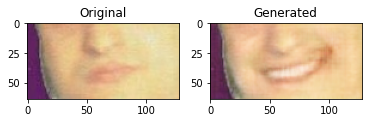

In [20]:
to_smile = smile_generator(example_neutral)

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(example_neutral[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Generated")
plt.imshow(to_smile[0] * 0.5 + 0.5)
plt.show()

# Demonstration

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
for f in uploaded: 
  print(f)
  run_smile_model(f,1)